# Edge detection with k-means

# Importing image to find the edges of via clustering

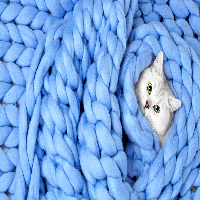

In [4]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import os

# calculating 3 features for each pixel

In [8]:
def features_pad(pix):
    pix_ext=np.pad(pix, (1, 1), 'symmetric')
    mid= pix_ext[1:-1,1:-1]
    N=pix_ext[0:-2,1:-1]-mid
    S=pix_ext[2:,1:-1]-mid
    E=pix_ext[1:-1,2:]-mid
    W=pix_ext[1:-1,0:-2]-mid
    NE = pix_ext[0:-2,2:]-mid
    NW=pix_ext[0:-2,0:-2]-mid
    SE = pix_ext[2:,2:]-mid
    SW=pix_ext[2:,0:-2]-mid
    F1=(1./8*( N**2 + S**2 + E**2 + W**2 + NE**2+ NW**2 + SE**2 + SW**2 ))**0.5
    F3=np.sqrt( N**2 + S**2 + E**2 + W**2  )
    pix_ext=np.pad(pix, (1, 1), 'constant', constant_values=(0, 0))
    mid= pix_ext[1:-1,1:-1]
    N=pix_ext[0:-2,1:-1]
    S=pix_ext[2:,1:-1]
    E=pix_ext[1:-1,2:]
    W=pix_ext[1:-1,0:-2]
    NE = pix_ext[0:-2,2:]
    NW=pix_ext[0:-2,0:-2]
    SE = pix_ext[2:,2:]
    SW=pix_ext[2:,0:-2]
    F2=np.abs(1/8*(N+S+E+W+NE+NW+SE+SW) - mid)
    m,n=pix.shape
    X=np.zeros([len(F3),3])
    X=np.zeros([(m-2)*(n-2),3])
    X[:,0],X[:,1],X[:,2] = F1[1:-1,1:-1].flatten(),F2[1:-1,1:-1].flatten(),F3[1:-1,1:-1].flatten()
    return X

# calculating 3 features for each pixel according to the paper using loops

In [9]:
def features_loop(p):
    m,n=p.shape
    f1=np.zeros(p.shape)
    f2=np.zeros(p.shape)
    f3=np.zeros(p.shape)

    for i in range(1,m-1):
        for j in range(1,n-1):
            p_others_4= np.array([p[i-1,j],p[i+1,j],p[i,j-1],p[i,j+1]])
            p_all_others = np.array([p[i-1,j],p[i+1,j],p[i,j-1],p[i,j+1],p[i-1,j-1],p[i-1,j+1],p[i+1,j-1],p[i+1,j+1]])
            f1[i,j] = np.sqrt(np.mean((p_all_others-p[i,j])**2))
            f3[i,j] = np.sqrt(np.sum((p_others_4-p[i,j])**2))
            f2[i,j] = np.abs(np.mean(p_all_others) - p[i,j])
    X=np.zeros([(m-2)*(n-2),3])
    X[:,0],X[:,1],X[:,2] = f1[1:-1,1:-1].flatten(),f2[1:-1,1:-1].flatten(),f3[1:-1,1:-1].flatten()
    return X

In [63]:
## checking difference in features in loop and padding case
X=features_loop(pix)
X1=features_pad(pix) 
#(np.abs(X1[:,0]-X[:,0]) >0.1).sum(),(np.abs(X1[:,1]-X[:,1]) >0.1).sum(),(np.abs(X1[:,2]-X[:,2]) >0.1).sum() ## how?

# run k-means on the pixels using feature matrix , no. of clusters =2

In [64]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=3, random_state=0).fit(X) ## loop case works!
#ans=kmeans.predict( X)

ans = kmeans.labels_
plt.figure(figsize=(10,13))
plt.imshow(255*ans.reshape(m-2,n-2), cmap='hot') 


In [66]:
img = Image.fromarray(255*ans.reshape(m-2,n-2))
img = img.convert("L")
img.show()
f1=f+'k_means_2clust.jpg'
img = img.save(f1) 

# run k-means on the pixels using feature matrix , no. of clusters =4

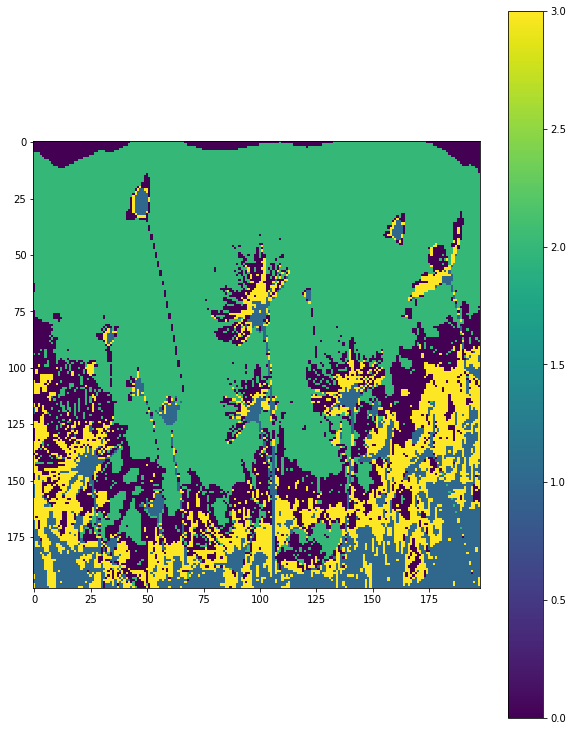

In [54]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=500, n_init=10, random_state=0).fit(X1) ## padding case better
#ans=kmeans.predict( X)
ans = kmeans.labels_
plt.figure(figsize=(10,13))
plt.imshow(ans.reshape(m-2,n-2)) 
plt.colorbar()

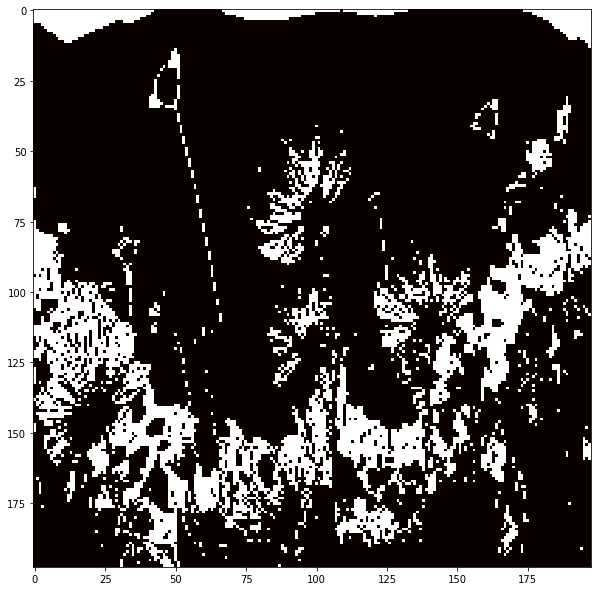

In [56]:
ans1=ans.copy()

## in case of four clusters:

ans1[ans==0] =1 #for extracting edge cluster
ans1[ans!=0] = 0 # for extracting edge cluster

ans1=ans1.reshape(m-2,n-2) 
plt.figure(figsize=(10,13))
plt.imshow(ans1,cmap='hot')


In [370]:
img = Image.fromarray(255*ans1)
img = img.convert("L")
img.show()
f1=f+'k_means_4clust.jpg'
img = img.save(f1) 

In [215]:
kmeans.get_params

<bound method BaseEstimator.get_params of KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)>

In [22]:
def image_grid(image_paths, func, fig_size = (15, 8)):
    num_images = len(image_paths)
    fig = plt.figure(figsize = fig_size)
    for i, image_path in enumerate(image_paths):
        image,out_image=func(image_path)
        plt.subplot(2,num_images, i + 1)
        plt.imshow(image, cmap = "hot")
        plt.subplot(2,num_images, num_images + i + 1)
        plt.imshow(out_image, cmap = "hot")


In [36]:
def kmeans_out(image_path,width=200,height=200,save=False):
    image = Image.open(image_path)
    image=image.resize((width,height), resample=0)
    image = image.convert("LA")
    image = np.array(image)[:,:,0]
    X=features_loop(image)
    kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=1000, n_init=3, random_state=0).fit(X)
    out_image = kmeans.labels_
    out_image=out_image.reshape(width-2,height-2)
    if save == True :
        img = Image.fromarray(255*out_image)
        img = img.convert("L")
        file_name = os.path.basename(image_path )  #eds_report.csv
        location = os.path.dirname(image_path )
       # filename,file_ext=os.path.splitext(image_path)
        img = img.save(location+'/kmeans_out/'+file_name)
    return image,out_image

In [69]:
import pathlib
image_dir = '../../data/images/'
path_list = [image_dir + path for path in os.listdir(image_dir) if path.endswith('.jpg')]

#for path in path_list:
#    kmeans_out(path,save=True,height=400,width=400)

In [70]:
im_idx=[1,3,5,9,-2]
[path_list[idx] for idx in im_idx ]


['../../data/images/cat.jpg',
 '../../data/images/Drawing Hands - MC Escher.jpg',
 '../../data/images/flowers.jpg',
 '../../data/images/paperboats.jpg',
 '../../data/images/The persistence of memory - Salvador Dali.jpg']